# ***Introduction to Radar Using Python and MATLAB***
## Andy Harrison - Copyright (C) 2019 Artech House
<br/>

# Backprojection (2D)
***

The backprojection imaging process is as follows;

1. Construct the spatial domain target density array $f (x_i , y_j)$.
2. Pulse compress return signals and perform filtering.
3. Upsample the returns for better image quality. Upsample factors can be large $( > 100 )$.
4. For a given pixel point, $(x_i , y_j)$, find the nearest upsampled time point (interpolate) and add the value of the filtered data to the array component $f (x_i , y_j)$.
5. Repeat for all pixel locations $(x_i , y_j)$ and all pulses.

The filtered backprojection algorithm has several advantages.  It is computationally efficient and employs the fast Fourier transform (FFT).  It is highly parallelizable as each projection's contribution and each pixel's value may be computed separately.  Also, image reconstruction may begin as soon as the first projection function is obtained, rather than waiting for all projections to be collected.  Finally, the filtered backprojection algorithm does not depend on uniform angular sampling in the projection data, and multiple object rotations or platform passes can be used.
***

Begin by getting the library path

In [1]:
import lib_path

Set the range to the center of the image (m), the **x** location of the target, they **y** location of the target, the target RCS (m^2)

In [2]:
range_center = 1e3

xt = [-3.0, 4.0]

yt = [1.0, -2.0]

rt = [1.0, 10.0]

Set image span in the **x** and **y** directions

In [3]:
x_span = 12.0

y_span = 12.0

Set the number of bins in the **x** and **y** directions

In [4]:
nx = 200

ny = 200

Set the start freuqency (Hz) and the bandwidth (Hz) of the transmitted signal

In [5]:
start_frequency = 1e9

bandwidth = 100e6

Set up the azimuth space

In [6]:
from scipy.constants import c

from numpy import sqrt, linspace, radians


az_start = -3.0

az_end = 3.0


r = sqrt(x_span ** 2 + y_span ** 2)

da = c / (2.0 * r * start_frequency)

na = int(radians(az_end - az_start) / da)

az = linspace(az_start, az_end, na)

Set up the frequency space

In [7]:
from scipy.fftpack import next_fast_len


df = c / (2.0 * r)

nf = int(bandwidth / df)

frequency = linspace(start_frequency, start_frequency + bandwidth, nf)

Set up the FFT length

In [8]:
from scipy.fftpack import next_fast_len

fft_length = 8 * next_fast_len(nf)

Set up the aperture positions

In [9]:
from numpy import sin, cos, radians, zeros_like

sensor_x = range_center * cos(radians(az))

sensor_y = range_center * sin(radians(az))

sensor_z = zeros_like(sensor_x)

Set up the image space

In [10]:
from numpy import meshgrid


xi = linspace(-0.5 * x_span, 0.5 * x_span, nx)

yi = linspace(-0.5 * y_span, 0.5 * y_span, ny)

x_image, y_image = meshgrid(xi, yi)

z_image = zeros_like(x_image)

Calculate the signal (k-space)

In [11]:
from numpy import zeros, dot, exp

from scipy.constants import pi

signal = zeros([nf, na], dtype=complex)


index = 0

for a in az:

    r_los = [cos(radians(a)), sin(radians(a))]


    for x, y, r in zip(xt, yt, rt):

        r_target = -dot(r_los, [x, y])

        signal[:, index] += r * exp(-1j * 4.0 * pi * frequency / c * r_target)

    index += 1

Get the window coefficients

In [12]:
from scipy.signal.windows import hann, hamming

from numpy import outer, ones


window_type = 'Hanning'



if window_type == 'Hanning':

    h1 = hann(nf, True)

    h2 = hann(na, True)

    coefficients = sqrt(outer(h1, h2))

elif window_type == 'Hamming':

    h1 = hamming(nf, True)

    h2 = hamming(na, True)

    coefficients = sqrt(outer(h1, h2))

elif window_type == 'Rectangular':

    coefficients = ones([nf, na])

Apply the windowing coefficients

In [13]:
signal *= coefficients

Reconstruct the image using the `backprojection` routines

In [14]:
from Libs.sar import backprojection

bp_image = backprojection.reconstruct(signal, sensor_x, sensor_y, sensor_z, range_center, x_image, y_image, z_image, frequency, fft_length)

Set the dynamic range for the image (dB)

In [15]:
dynamic_range = 40

Display the backprojection image using the `matplotlib` routines

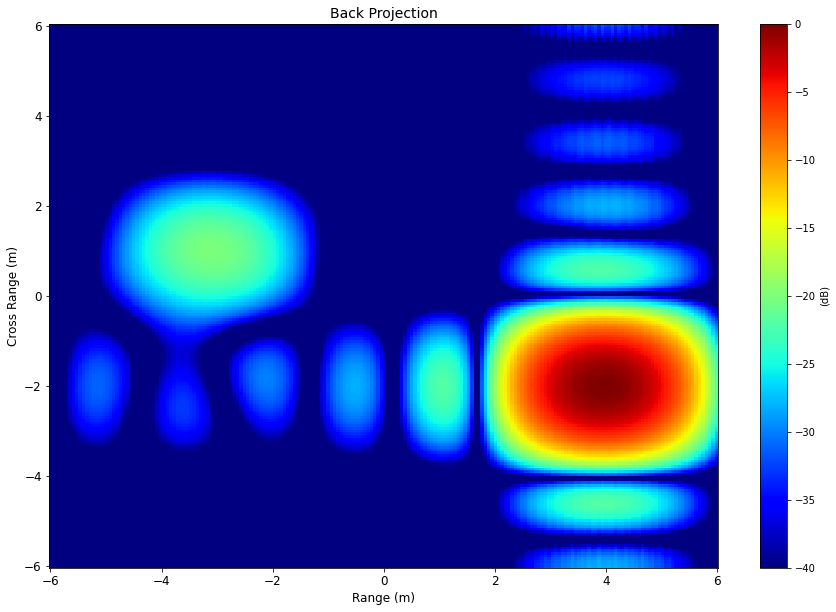

In [16]:
from matplotlib import pyplot as plt

from numpy import log10, amax


# Normalize the image

bpi = abs(bp_image) / amax(abs(bp_image))



# Set the figure size

plt.rcParams["figure.figsize"] = (15, 10)


# Set up the axes

fig, axes1 = plt.subplots()


# create the color plot

im = axes1.pcolor(xi, yi, 20.0 * log10(bpi), cmap='jet', vmin=-dynamic_range, vmax=0, shading = 'auto')

cbar = fig.colorbar(im, ax=axes1, orientation='vertical')

cbar.set_label("(dB)", size=10)



# Set the plot title and labels

axes1.set_title('Back Projection', size=14)

axes1.set_xlabel('Range (m)', size=12)

axes1.set_ylabel('Cross Range (m)', size=12)



# Set the tick label size

axes1.tick_params(labelsize=12)